## Library import

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import random
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Exploration

In [2]:
df=pd.read_csv('TRAIN.csv')
df.head()

,wconfid,pctid,x,y,z
0,1,20,1.004,0.090,-0.125
1,1,20,1.004,-0.043,-0.125
2,1,20,0.969,0.090,-0.121
3,1,20,0.973,-0.012,-0.137
4,1,20,1.000,-0.016,-0.121


In [3]:
dfs_per_config = list(zip(* df.groupby(['wconfid','pctid'])))[1]
print(len(dfs_per_config))

51


In [45]:
import random
rand_config=random.choice(dfs_per_config).reset_index(drop=True)

### Visualisation de la trajectoire 
Generation d'une vidéo d'animation du mouvement

In [58]:
# Importing Packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation


def animate_func(num):
    ax.clear()  # Clears the figure to update the line, point,   
                # title, and axes
    # Updating Trajectory Line (num+1 due to Python indexing)
    ax.plot3D(dataSet[0, :num+1], dataSet[1, :num+1], 
              dataSet[2, :num+1], c='blue')
    # Updating Point Location 
    ax.scatter(dataSet[0, num], dataSet[1, num], dataSet[2, num], 
               c='blue', marker='o')
    # Adding Constant Origin
    ax.plot3D(dataSet[0, 0], dataSet[1, 0], dataSet[2, 0],     
               c='black', marker='o')
    CTE_WIDTH=1
    # Setting Axes Limits
    ax.set_xlim3d([rand_config.x.min()*CTE_WIDTH, rand_config.x.max()*CTE_WIDTH])
    ax.set_ylim3d([rand_config.y.min()*CTE_WIDTH, rand_config.y.max()*CTE_WIDTH])
    ax.set_zlim3d([rand_config.z.min()*CTE_WIDTH, rand_config.z.max()*CTE_WIDTH])

    # Adding Figure Labels
    ax.set_title('Trajectory \nTime = ' + str(np.round(t[num],    
                 decimals=2)) + ' sec')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
import imageio
def gif_to_mp4(path , fps):
    gif = imageio.get_reader(path+".gif")
    mp4_writer = imageio.get_writer(path+".mp4", fps=fps)
    for frame in gif:
        mp4_writer.append_data(frame)
    mp4_writer.close()


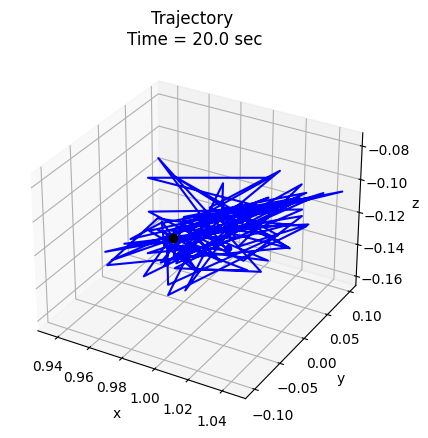

In [59]:
# Time Array
t = np.linspace(0, 20, 100)


# Setting up Data Set for Animation
dataSet = np.array([rand_config['x'].values, rand_config['y'].values, rand_config['z'].values]) # Combining our position coordinates
numDataPoints = len(t)

fig = plt.figure()
ax = plt.axes(projection='3d')
line_ani = animation.FuncAnimation(fig, animate_func, interval=100,   
                                   frames=numDataPoints,repeat=False)

f = r"./animation_random_sample.gif" 
writergif = animation.PillowWriter(fps=42) 
line_ani.save(f, writer=writergif)

gif_to_mp4("animation_random_sample",42)


## Data preparation
On va générer tout les échantillons possible de taille 32 -> 1 
Pour ce faire on va rouler une fenêtre tout au long du dataset 
On va essayer de le faire d'une façon un peu plus rapide qu'avec une boucle itérrant sur tout le dataset

In [17]:
def gen_samples_rolling_wind(ds , wind):
    no_sp_it=len(ds)//wind
    all_sp = []
    ind_sample = []
    for k in range(wind):
        const_Tab = np.split(ds[k:] , [wind*i for i in range(no_sp_it+1)])

        all_sp = all_sp + const_Tab
        ind_sample = ind_sample + [[wind*i+k for z in range(len(elem))] for i,elem in enumerate(const_Tab)]
    return all_sp , ind_sample

def gen_all_samples(ds,window):
    samples , indexes =gen_samples_rolling_wind(ds, window)
    alsp = pd.concat(samples)
    alsp['ind_sp']=np.concatenate(indexes).astype(int)
    alsp['ind_sp'] = alsp['ind_sp']-alsp['ind_sp'].min()
    alsp.reset_index(inplace=True)
    alsp.sort_values(['ind_sp','index'],inplace=True)
    limdf = len(ds)-window
    alsp = alsp[alsp.ind_sp<=limdf].reset_index(drop=True)
    return alsp

In [46]:
train_set = rand_config[['x','y','z']][0:2000+32].copy()
test_set = rand_config[['x','y','z']][2000+32:].copy()

In [47]:
als=list(zip(*gen_all_samples(train_set.copy(),33).groupby('ind_sp')))[1]
als = torch.cat([ torch.Tensor(e[['x','y','z']].values.reshape(1,33,3)) for e in als],axis=0)
train_samples=list(zip(als[:,0:32,:].reshape(-1,40,32,3),als[:,32,:].reshape(-1,40,3)))

In [48]:
len(train_samples)# 50 batchs de taille 40 chacun

50

In [49]:
train_samples[0][0].shape,train_samples[0][1].shape

(torch.Size([40, 32, 3]), torch.Size([40, 3]))

In [50]:
als_test = list(zip(*gen_all_samples(test_set.copy(),33).groupby('ind_sp')))[1]
als_test = torch.cat([ torch.Tensor(e[['x','y','z']].values.reshape(1,33,3)) for e in als_test],axis=0)
test_samples=als_test[:,0:32,:].reshape(-1,32,3),als_test[:,32,:].reshape(-1,3)

## Model 

In [51]:
class BaseLineGru(nn.Module):
    def __init__(self):
        super(BaseLineGru, self).__init__()
        self.hidden_size=50
        self.num_layers=1
        self.bidirec=2
        self.input_size=3
        self.rec_layer=torch.nn.GRU(input_size= self.input_size,hidden_size=self.hidden_size,num_layers=self.num_layers,
        batch_first=True,bidirectional=True)
        self.predict_sig = nn.Sequential(
                nn.Linear(32*self.bidirec* self.hidden_size , 3))
    def forward(self, x):
        output_rec, h_n = self.rec_layer(x.reshape(x.shape[0],x.shape[1],-1))
        pred_sig = self.predict_sig(output_rec.reshape(x.shape[0],-1))
        ## Inverse scaling
        return pred_sig

def train_loop(dataset,model,loss_fn,optimizer):

    for couple in dataset:
        x = couple[0]
        y_hat = model(x)
        y = couple[1]
        
        loss = loss_fn(
            y_hat,
            y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return 

In [ ]:
bsl_g = BaseLineGru().to(device)
criterion_g = torch.nn.MSELoss(reduction='mean') 
optimizer_g = torch.optim.Adam(bsl_g.parameters(), lr=1e-3,weight_decay = 1e-6)
epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_samples.copy(), bsl_g, criterion_g, optimizer_g)
    np.random.shuffle(train_samples)
    

In [53]:
y_hat_test = bsl_g(test_samples[0])

In [54]:
pred_set = test_set[32:]

In [55]:
pred_set[['x_hat','y_hat','z_hat']]=y_hat_test.detach().numpy()

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
/var/folders/cp/23h_lc1972z3pc9nw59kztgh0000gn/T/ipykernel_67703/3014656324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_set[['x_hat','y_hat','z_hat']]=y_hat_test.detach().numpy()
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

In [56]:
pred_set

,x,y,z,x_hat,y_hat,z_hat
2064,1.008,0.059,-0.113,1.000620,0.047954,-0.116285
2065,0.973,-0.031,-0.117,0.990363,-0.022542,-0.119872
2066,0.984,-0.039,-0.117,0.987823,0.000813,-0.121998
2067,1.039,0.059,-0.121,1.011233,0.018725,-0.106936
2068,0.992,-0.051,-0.141,0.990483,-0.006203,-0.134892
...,...,...,...,...,...,...
2495,0.984,-0.012,-0.141,0.968812,0.017518,-0.131967
2496,0.992,0.086,-0.109,1.005312,0.017377,-0.121362
2497,1.020,-0.082,-0.098,1.003038,0.000674,-0.119478
2498,0.977,0.000,-0.133,0.969636,-0.009144,-0.136378
